# 🛍️ Customer Segmentation for *UrbanTrends Retail*

## 1. Problem Statement
UrbanTrends Retail is an online and offline store that sells a variety of lifestyle products across multiple countries.  
Management wants to understand their customer base better in order to:
- Identify high-value customers.
- Create targeted marketing campaigns.
- Personalize offers and promotions.

We will use **transactional data** to segment customers based on purchasing behavior using **K-Means** and **Agglomerative Clustering**.

---

## 2. Dataset Overview
The dataset contains transactional records of customer purchases.

**Sample Fields:**
- **InvoiceNo**: Unique identifier for each transaction.
- **StockCode**: Product code.
- **Description**: Product description.
- **Quantity**: Number of units purchased.
- **InvoiceDate**: Date and time of the transaction.
- **UnitPrice**: Price per unit (in local currency).
- **CustomerID**: Unique identifier for each customer.
- **Country**: Country where the customer resides.

**Example Rows:**
| InvoiceNo | StockCode | Description | Quantity | InvoiceDate        | UnitPrice | CustomerID | Country |
|-----------|-----------|-------------|----------|--------------------|-----------|------------|---------|
| 536370    | 22728     | ALARM CLOCK BAKELIKE PINK | 24 | 01-12-2010 08:45 | 3.75      | 12583      | France  |
| 536852    | 22549     | PICTURE DOMINOES         | 12 | 03-12-2010 09:51 | 1.45      | 12686      | France  |

---

## 3. Exploratory Questions
Before diving into analysis, let's think about:
1. What features might indicate customer value or loyalty?
2. Should we focus on:
   - **Recency**: How recently did the customer purchase?
   - **Frequency**: How often do they purchase?
   - **Monetary**: How much do they spend in total?
3. Are there seasonal trends or country-based differences worth considering?
4. Should we treat cancellations (negative quantities) differently?

---

## 4. Feature Engineering

### 4.1 Why RFM Features?
The **RFM model** (Recency, Frequency, Monetary) is a proven approach for customer segmentation:
- **Recency (R)**: Days since last purchase (lower is better).
- **Frequency (F)**: Total number of purchases (higher is better).
- **Monetary (M)**: Total amount spent (higher is better).

### 4.2 Calculating RFM Features
Steps:
1. **Convert `InvoiceDate` to datetime format**.
2. **Define a reference date** (e.g., the day after the last transaction in the dataset).
3. **Group data by `CustomerID`**:
   - **Recency**: `(ReferenceDate - LastPurchaseDate).days`
   - **Frequency**: `Number of unique InvoiceNo`
   - **Monetary**: `Sum of (Quantity × UnitPrice)`

In [1]:
import pandas as pd
from datetime import datetime

# Load data
df = pd.read_csv("retail_data.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,01-12-2010 08:45,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,01-12-2010 08:45,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,01-12-2010 08:45,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,01-12-2010 08:45,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,01-12-2010 08:45,0.65,12583.0,France


In [21]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%d-%m-%Y %H:%M")

# Remove negative quantities (returns/cancellations)
df = df[df['Quantity'] > 0]

# Reference date for Recency calculation
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)



# Calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'UnitPrice': 'sum',  # temporary, we'll replace with total spend
})

# Calculate Monetary
monetary = df.groupby('CustomerID').apply(lambda x: (x['Quantity'] * x['UnitPrice']).sum())

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'TempPrice']
rfm['Monetary'] = monetary
rfm.drop(columns=['TempPrice'], inplace=True)

rfm.head()

C:\Users\sriam\AppData\Local\Temp\ipykernel_20716\2216645722.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monetary = df.groupby('CustomerID').apply(lambda x: (x['Quantity'] * x['UnitPrice']).sum())


,Recency,Frequency,Monetary
CustomerID,,,
12413.0,67,3,758.10
12437.0,2,18,4951.41
12441.0,367,1,173.55
12488.0,10,3,1298.66
12489.0,336,1,334.93


In [3]:
rfm.shape

(87, 3)

(array([ 3.,  6.,  8., 10.,  8., 15.,  8., 10.,  4., 15.]),
 array([0.69314718, 1.2159903 , 1.73883343, 2.26167655, 2.78451968,
        3.3073628 , 3.83020592, 4.35304905, 4.87589217, 5.3987353 ,
        5.92157842]),
 <BarContainer object of 10 artists>)

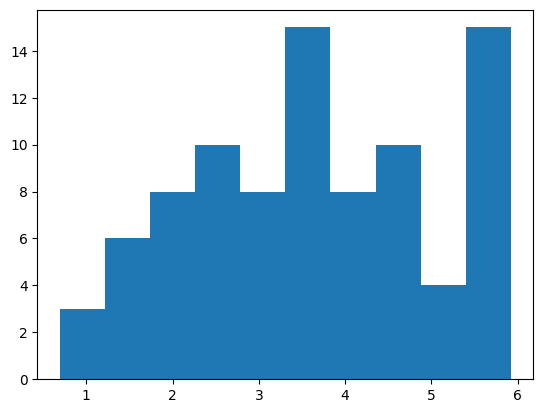

In [23]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

plt.hist(np.log1p(rfm['Recency']))

## 4.3 Transform & Scale (log1p for skew, then StandardScaler)

In [24]:
from sklearn.preprocessing import StandardScaler
import numpy as np
rfm_transformed = rfm.copy()
for col in ['Recency', 'Frequency', 'Monetary']:
    rfm_transformed[f'log_{col}'] = np.log1p(rfm_transformed[col])

X_cols = ['log_Recency', 'log_Frequency', 'log_Monetary']
scaler = StandardScaler()
X = scaler.fit_transform(rfm_transformed[X_cols])

In [ ]:
X[:5], rfm_transformed[X_cols].head()

(array([[ 0.40228978, -0.05601718, -0.21105863],
        [-1.8131261 ,  2.19419812,  1.20652325],
        [ 1.60095103, -1.0570349 , -1.3220901 ],
        [-0.89080998, -0.05601718,  0.195377  ],
        [ 1.53848286, -1.0570349 , -0.82724561]]),
             log_Recency  log_Frequency  log_Monetary
 CustomerID                                          
 12413.0        4.219508       1.386294      6.632134
 12437.0        1.098612       2.944439      8.507630
 12441.0        5.908083       0.693147      5.162211
 12488.0        2.397895       1.386294      7.169858
 12489.0        5.820083       0.693147      5.816903)

## 5. K-Means: Elbow & Silhouette to choose k

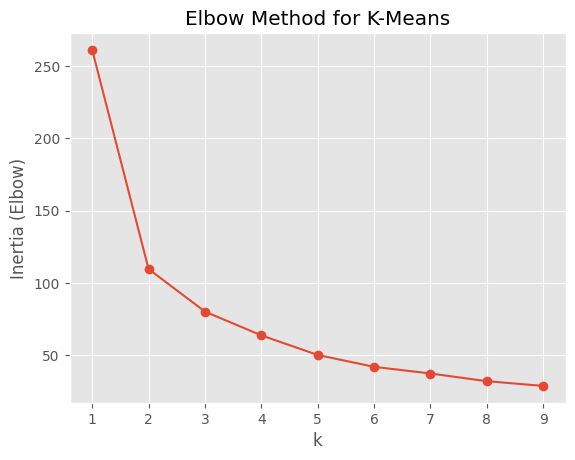

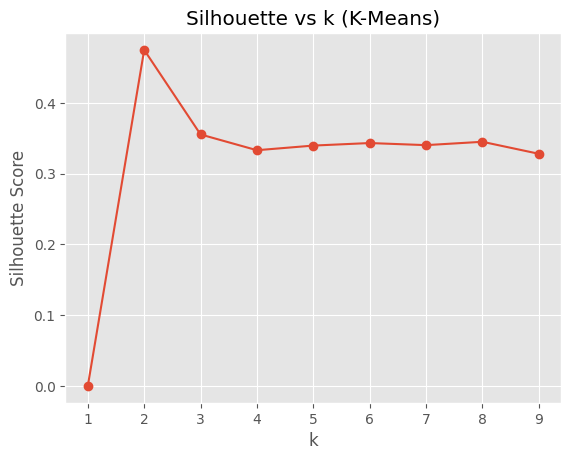

2

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

ks = range(1, 10)
inertias, sils = [], []

for k in ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=10)
    labels_k = km.fit_predict(X)
    inertias.append(km.inertia_)
    if k==1:
        continue
    else:
        sils.append(silhouette_score(X, labels_k))

plt.figure()
plt.plot(list(ks), inertias, marker='o')
plt.xlabel('k'); plt.ylabel('Inertia (Elbow)'); plt.title('Elbow Method for K-Means')
plt.show()

sils.insert(0,0)
plt.figure()
plt.plot(list(ks), sils, marker='o')
plt.xlabel('k'); plt.ylabel('Silhouette Score'); plt.title('Silhouette vs k (K-Means)')
plt.show()

best_k = ks[int(np.argmax(sils))]
best_k


In [16]:
rfm.shape

(87, 3)

In [26]:
rfm.head(2)

,Recency,Frequency,Monetary
CustomerID,,,
12413.0,67,3,758.10
12437.0,2,18,4951.41


## 6. Fit Final K-Means and Attach to RFM

In [42]:
k_final = int(best_k)  # or set manually, e.g., 4
km_final = KMeans(n_clusters=4, n_init=50, random_state=42)

In [43]:
km_final.fit_predict(X)

array([0, 3, 1, 2, 1, 3, 0, 1, 2, 1, 0, 1, 0, 2, 0, 0, 2, 3, 2, 1, 3, 0,
       1, 1, 0, 0, 3, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 1, 1,
       2, 2, 0, 0, 0, 2, 1, 2, 3, 0, 2, 3, 3, 3, 2, 2, 1, 0, 1, 2, 0, 2,
       2, 1, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 3, 1, 1, 1, 1, 0, 2],
      dtype=int32)

In [44]:
rfm_transformed

,CustomerID,Recency,Frequency,Monetary,log_Recency,log_Frequency,log_Monetary,KM_Label,AGG_Label
0,12413.0,67,3,758.10,4.219508,1.386294,6.632134,0,0
1,12437.0,2,18,4951.41,1.098612,2.944439,8.507630,1,1
2,12441.0,367,1,173.55,5.908083,0.693147,5.162211,0,0
3,12488.0,10,3,1298.66,2.397895,1.386294,7.169858,1,0
4,12489.0,336,1,334.93,5.820083,0.693147,5.816903,0,0
...,...,...,...,...,...,...,...,...,...
82,12734.0,353,1,110.40,5.869297,0.693147,4.713127,0,0
83,12735.0,315,2,779.57,5.755742,1.098612,6.660024,0,0
84,12736.0,333,1,234.00,5.811141,0.693147,5.459586,0,0
85,12740.0,64,1,427.60,4.174387,0.693147,6.060524,0,0


In [45]:
rfm_transformed['KM_Label'] = km_final.fit_predict(X)

km_sil = silhouette_score(X, rfm_transformed['KM_Label'])
km_sil

np.float64(0.33305061862379304)

In [46]:
rfm_transformed

,CustomerID,Recency,Frequency,Monetary,log_Recency,log_Frequency,log_Monetary,KM_Label,AGG_Label
0,12413.0,67,3,758.10,4.219508,1.386294,6.632134,0,0
1,12437.0,2,18,4951.41,1.098612,2.944439,8.507630,3,1
2,12441.0,367,1,173.55,5.908083,0.693147,5.162211,1,0
3,12488.0,10,3,1298.66,2.397895,1.386294,7.169858,2,0
4,12489.0,336,1,334.93,5.820083,0.693147,5.816903,1,0
...,...,...,...,...,...,...,...,...,...
82,12734.0,353,1,110.40,5.869297,0.693147,4.713127,1,0
83,12735.0,315,2,779.57,5.755742,1.098612,6.660024,1,0
84,12736.0,333,1,234.00,5.811141,0.693147,5.459586,1,0
85,12740.0,64,1,427.60,4.174387,0.693147,6.060524,0,0


## 7. Agglomerative Clustering (with the same k)

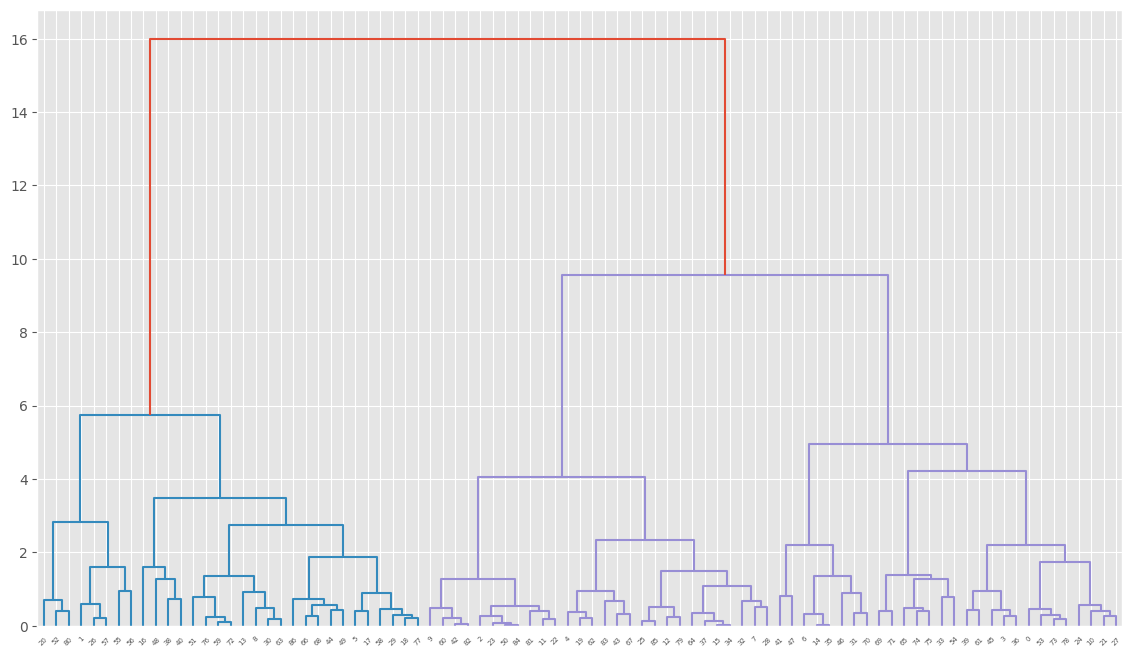

In [47]:
from scipy.cluster.hierarchy import linkage, dendrogram
z = linkage(X,method="ward",metric="euclidean")
plt.figure(figsize=(14,8))
dendrogram(z, labels=rfm.index.tolist())
plt.xticks(rotation=45)
plt.show()

In [48]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=4, linkage='ward', metric='euclidean')
rfm_transformed['AGG_Label'] = agg.fit_predict(X)

agg_sil = silhouette_score(X, rfm_transformed['AGG_Label'])
agg_sil


np.float64(0.31229011668934803)

In [49]:
rfm_transformed.head()

,CustomerID,Recency,Frequency,Monetary,log_Recency,log_Frequency,log_Monetary,KM_Label,AGG_Label
0,12413.0,67,3,758.10,4.219508,1.386294,6.632134,0,0
1,12437.0,2,18,4951.41,1.098612,2.944439,8.507630,3,3
2,12441.0,367,1,173.55,5.908083,0.693147,5.162211,1,2
3,12488.0,10,3,1298.66,2.397895,1.386294,7.169858,2,0
4,12489.0,336,1,334.93,5.820083,0.693147,5.816903,1,2


## 8. PCA 2D Visualization (K-Means vs Agglomerative)

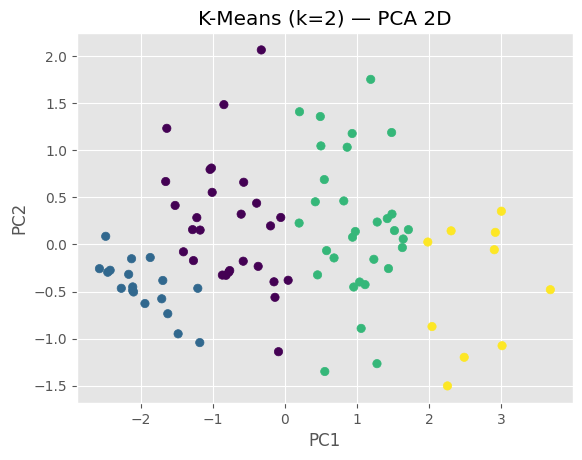

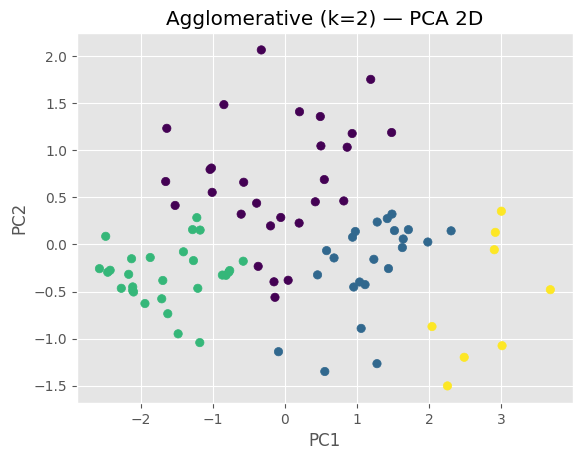

In [50]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X)

fig, ax = plt.subplots()
scatter = ax.scatter(X2[:,0], X2[:,1], c=rfm_transformed['KM_Label'])
ax.set_title(f'K-Means (k={k_final}) — PCA 2D'); ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
plt.show()

fig, ax = plt.subplots()
scatter = ax.scatter(X2[:,0], X2[:,1], c=rfm_transformed['AGG_Label'])
ax.set_title(f'Agglomerative (k={k_final}) — PCA 2D'); ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
plt.show()


## 9. Cluster Profiling (means, medians, counts)

In [51]:
rfm.reset_index(inplace=True)
rfm_transformed.reset_index(inplace=True)

In [52]:
def profile_clusters(df_labels, label_col):
    # Bring back original (unlogged) RFM for interpretability
    prof = (
        rfm.reset_index()[['CustomerID', 'Recency', 'Frequency', 'Monetary']]
        .merge(df_labels[['CustomerID', label_col]], on='CustomerID', how='left')
        .groupby(label_col)
        .agg(
            Customers=('CustomerID', 'nunique'),
            Recency_mean=('Recency', 'mean'),
            Frequency_mean=('Frequency', 'mean'),
            Monetary_mean=('Monetary', 'mean'),
            Recency_median=('Recency', 'median'),
            Frequency_median=('Frequency', 'median'),
            Monetary_median=('Monetary', 'median'),
        )
        .sort_index()
    )
    prof['Share_%'] = 100 * prof['Customers'] / prof['Customers'].sum()
    return prof.round(2)

In [53]:
km_profile = profile_clusters(rfm_transformed, 'KM_Label')


In [54]:
km_profile

,Customers,Recency_mean,Frequency_mean,Monetary_mean,Recency_median,Frequency_median,Monetary_median,Share_%
KM_Label,,,,,,,,
0,28,63.61,1.93,631.20,65.5,2.0,490.00,32.18
1,18,290.94,1.11,318.32,315.5,1.0,229.95,20.69
2,31,20.68,5.16,2703.22,11.0,5.0,2283.63,35.63
3,10,13.00,15.50,10182.10,6.5,13.5,8938.92,11.49


In [55]:
profile_clusters(rfm_transformed, 'AGG_Label')

,Customers,Recency_mean,Frequency_mean,Monetary_mean,Recency_median,Frequency_median,Monetary_median,Share_%
AGG_Label,,,,,,,,
0,28,28.50,2.57,786.79,26.0,2.5,691.44,32.18
1,23,31.17,6.30,3609.01,17.0,6.0,3023.08,26.44
2,28,219.89,1.32,402.71,230.0,1.0,403.55,32.18
3,8,14.62,16.88,11588.85,9.5,15.0,10844.75,9.20
